## Cifar10 Datset 신경망에서 훈련

In [1]:
!nvidia-smi

Sun Oct 17 17:46:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8     7W /  N/A |    589MiB /  3072MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#import libraries
import tensorflow as tf 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
tf.__version__

'2.3.0'

In [6]:
tf.keras.__version__

'2.4.0'

## 데이터 적재

In [7]:
# load datasets
from tensorflow.keras.datasets import cifar10

In [8]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 19s 0us/step


In [9]:
train_images.shape, train_labels.shape

((50000, 32, 32, 3), (50000, 1))

In [11]:
train_images[0].shape

(32, 32, 3)

In [12]:
test_images.shape, test_labels.shape

((10000, 32, 32, 3), (10000, 1))

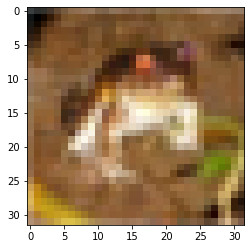

In [13]:
plt.imshow(train_images[0])

In [19]:
train_labels[0]

array([6], dtype=uint8)

In [20]:
# naming to class 
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [22]:
train_labels = np.int32(train_labels.flatten())
train_labels

array([6, 9, 9, ..., 9, 1, 1])

In [23]:
len(train_labels)

50000

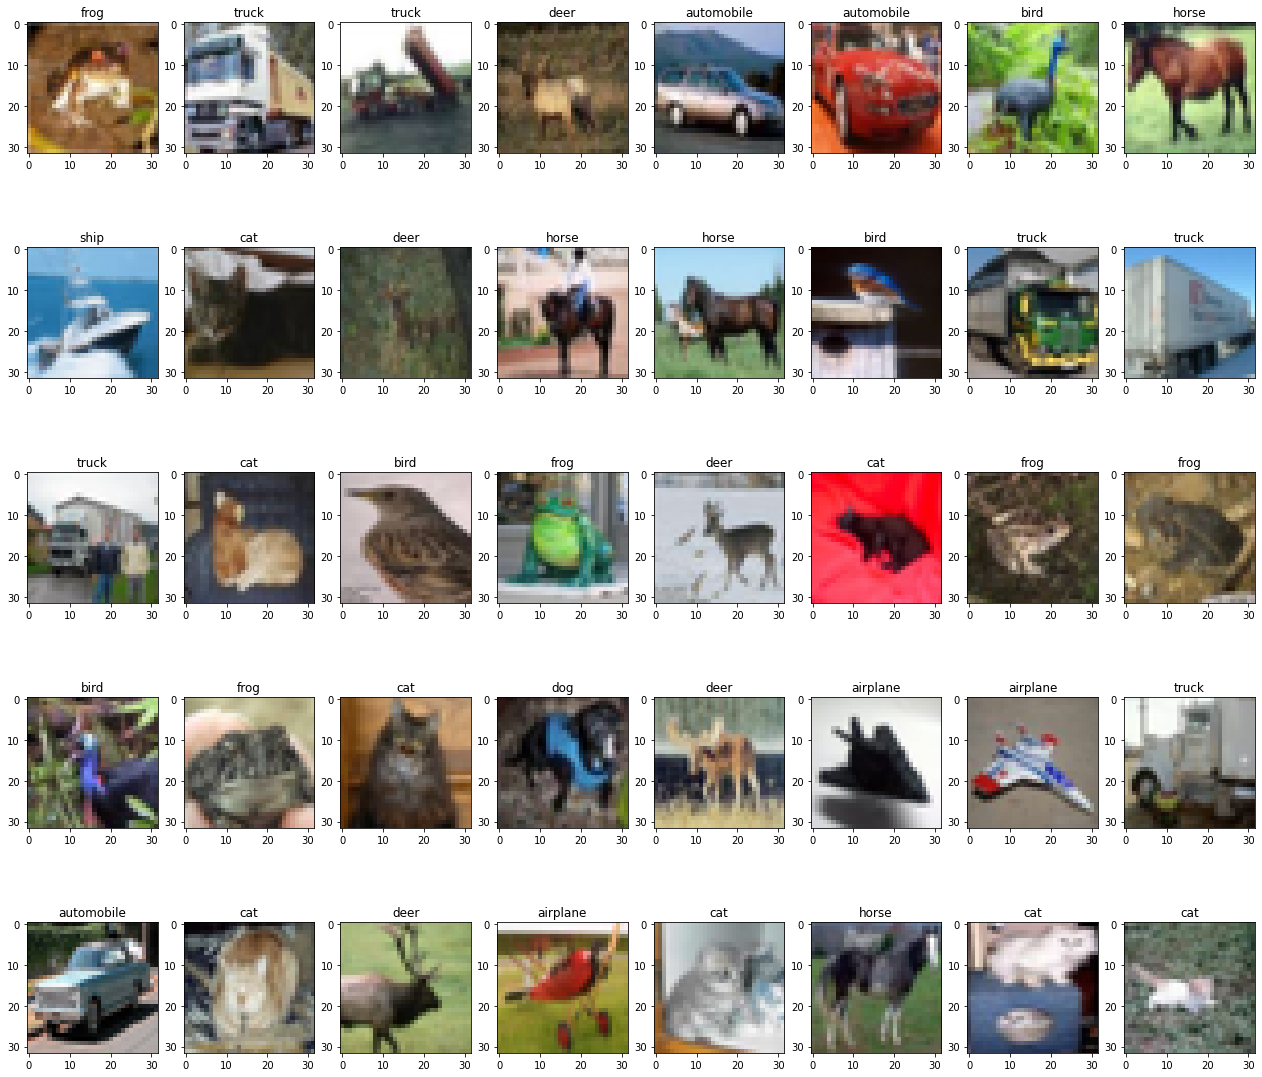

In [25]:
fig, ax = plt.subplots(figsize=(22,20), nrows=5, ncols=8)
for i in range(5):
    for j in range(8):
        ax[i][j].imshow(train_images[(i*8)+j])
        ax[i][j].set_title(class_names[train_labels[(i*8+j)]])

In [26]:
train_labels[:8]

array([6, 9, 9, 4, 1, 1, 2, 7])

## 데이터 전처리

In [27]:
#data preprocessing
# normalization
train_images = np.array(train_images/255.0, dtype=np.float32)
train_labels = np.array(train_labels, dtype=np.float32)

test_images = np.array(test_images/255.0, dtype=np.float32)
test_labels = np.array(test_labels, dtype=np.float32)

In [28]:
# one hot encoding
train_labels_ohe = to_categorical(train_labels)
test_labels_ohe = to_categorical(test_labels)

### 데이터 증강(샘플 예시)

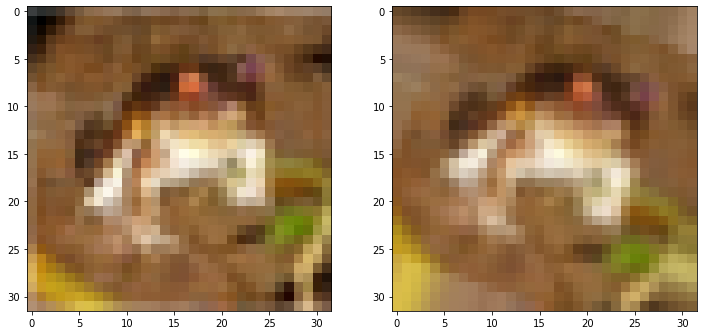

In [30]:
#data_generator = ImageDataGenerator(horizontal_flip=True)
# data_generator = ImageDataGenerator(vertical_flip=True)
data_generator = ImageDataGenerator(rotation_range=50)

origin_image = np.expand_dims(train_images[0], axis=0) #3차원으로 변경
train_image_gen = data_generator.flow(origin_image)
augmented_image = next(train_image_gen)
augmented_image = np.squeeze(augmented_image) # 2차원으로 축소 
origin_image = np.squeeze(origin_image) #2차원으로 축소

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
ax[0].imshow(origin_image)
ax[1].imshow(augmented_image)

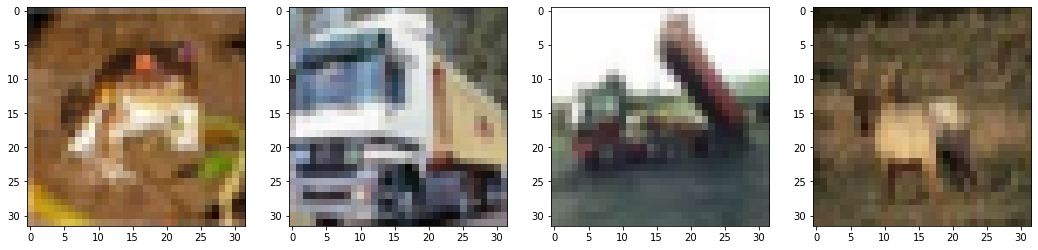

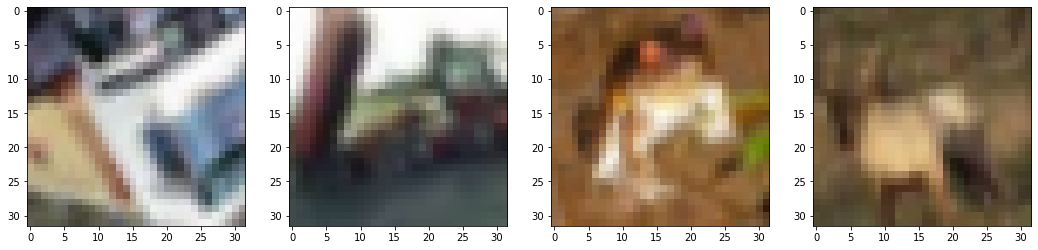

In [31]:
data_generator = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=30, 
                                   zoom_range=(0.7, 0.9))
origin_images = train_images[:4]
train_image_gen = data_generator.flow(origin_images)

augmented_images = next(train_image_gen)

fig1, ax = plt.subplots(nrows=1, ncols=4, figsize=(18,6))
for i , image in enumerate(origin_images):
    ax[i].imshow(image)
    
fig2, ax = plt.subplots(nrows=1, ncols=4, figsize=(18,6))
for i , image in enumerate(augmented_images):
    ax[i].imshow(image)

## 데이터 증강

In [32]:
from sklearn.model_selection import train_test_split

In [34]:
train_images, valid_images, train_labels_ohe, valid_labels_ohe = train_test_split(
    train_images, train_labels_ohe, test_size=0.2, random_state=42)

### 데이터 증강 + 배치 정규화

In [35]:
batch_size=64

train_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True, 
                                    rotation_range=30,
                                    zoom_range=(0.7, 0.9))
valid_generator = ImageDataGenerator()

train_flow_gen = train_generator.flow(train_images, train_labels_ohe, batch_size=batch_size )
valid_flow_gen = valid_generator.flow(valid_images, valid_labels_ohe, batch_size=batch_size)

In [38]:
# modeling

def build_model():
    tf.keras.backend.clear_session()
    
    input_tensor = Input(shape=(32,32,3))
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    return model
    
    

In [39]:
model = build_model()

In [40]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)       

In [41]:
# model compileing
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
checkpoint_cb = ModelCheckpoint('cifar_211017.h5',save_best_only=True,verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=22,restore_best_weights=True )
reducelr_cb = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=10, verbose=1)

In [44]:
history = model.fit(train_flow_gen, validation_data=valid_flow_gen, epochs=15, verbose=1,
                   callbacks=[checkpoint_cb, early_stopping_cb, reducelr_cb])

Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 1.9595 - accuracy: 0.2659
Epoch 00001: val_loss improved from inf to 1.84687, saving model to cifar_211017.h5
625/625 [==============================] - 192s 306ms/step - loss: 1.9595 - accuracy: 0.2659 - val_loss: 1.8469 - val_accuracy: 0.3187
Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 1.6902 - accuracy: 0.3674
Epoch 00002: val_loss did not improve from 1.84687
625/625 [==============================] - 190s 305ms/step - loss: 1.6902 - accuracy: 0.3674 - val_loss: 2.2313 - val_accuracy: 0.2873
Epoch 3/15
625/625 [==============================] - ETA: 0s - loss: 1.5472 - accuracy: 0.4310
Epoch 00003: val_loss improved from 1.84687 to 1.78185, saving model to cifar_211017.h5
625/625 [==============================] - 191s 305ms/step - loss: 1.5472 - accuracy: 0.4310 - val_loss: 1.7819 - val_accuracy: 0.3713
Epoch 4/15
625/625 [==============================] - ETA: 0s - loss: 1.4553 - accur

In [45]:
# 모델 평가 
model.evaluate(test_images, test_labels_ohe, batch_size=128)

79/79 [==============================] - 6s 73ms/step - loss: 1.3123 - accuracy: 0.5732


[1.3123431205749512, 0.573199987411499]

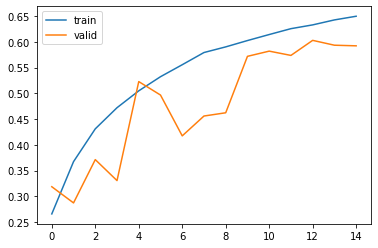

In [46]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()